In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.spatial.transform import Rotation
from sympy import Matrix, pi, pprint
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class TNG50DataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.chunk_size = 102609 // 9
        self.load_data()

    def load_data(self):
        chunks = pd.read_csv(self.file_path, sep=' ', names=['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho'], header=None, chunksize=self.chunk_size)
        self.accumulated_data = np.concatenate([chunk.values for chunk in chunks])

    def calculate_center_of_mass_new(self, value_energy=2.63):
        Log_energy = np.log10(self.accumulated_data[:, 10])
        avg_energy = np.mean(Log_energy)
        if value_energy == 1:
            value_energy = avg_energy
        energy_filter = Log_energy < value_energy
        self.filtered_data = self.accumulated_data[energy_filter]
        return np.sum(self.filtered_data[:, :3], axis=0) / len(self.accumulated_data)

    def calculate_total_angular_momentum(self):
        center_of_mass = self.calculate_center_of_mass_new()
        r_i = self.filtered_data[:, :3] - center_of_mass
        v_i = self.filtered_data[:, 3:6] - self.calculate_velocity_of_mass()
        return np.sum(np.cross(r_i, v_i), axis=0)

    def calculate_velocity_of_mass(self):
        return np.mean(self.filtered_data[:, 3:6], axis=0)

class RotationHandler:
    def __init__(self, direction):
      self.direction = direction
      direction = angular_direction[largest_component]
      pass

    def choose_rotation_matrix(self, largest_component, direction):
        if largest_component == 0:
            if direction == 1:
                matrix = Rotation.from_euler('y', -pi/2).as_matrix()
            elif direction == -1:
                matrix = Rotation.from_euler('y', pi/2).as_matrix()
        elif largest_component == 1:
            if direction == 1:
                matrix = Rotation.from_euler('x', pi/2).as_matrix()
            elif direction == -1:
                matrix = Rotation.from_euler('x', -pi/2).as_matrix()
        elif largest_component == 2:
            if direction == 1:
                matrix = np.identity(3)
            elif direction == -1:
                matrix = Rotation.from_euler('z', pi).as_matrix()
        return matrix

    def apply_rotation(self, matrix, vector):
        rotated_array = np.zeros_like(vector)
        if vector.size == 3:
            rotated_array = np.dot(matrix, vector)
        else:
            for i in range(vector.shape[0]):
                rotated_array[i, :] = np.dot(matrix, vector[i, :])
        return rotated_array

class VelocityEscapeCalculator:
    def __init__(self, data, potential):
        self.data = data
        self.potential = potential

    def calculate_magnitudes(self):
        velocity_magnitude = np.sqrt(np.sum(self.data[:, 3:6]**2, axis=1)).reshape(-1, 1)
        position_magnitude = np.sqrt(np.sum(self.data[:, :3]**2, axis=1)).reshape(-1, 1)
        self.data = np.concatenate([self.data, velocity_magnitude, position_magnitude], axis=1)

    def calculate_escape_velocity(self):
        escape_velocity = np.sqrt(2 * np.abs(self.potential)).reshape(-1, 1)
        self.data = np.concatenate([self.data, escape_velocity], axis=1)

    def get_processed_data(self):
        columns = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho', 'velocity_magnitude', 'position_magnitude', 'escape_velocity']
        return pd.DataFrame(self.data, columns=columns)

class VisualizationHandler:
    def visualize_galaxy_one(self, rotated_vectors_filtered, center_of_mass, ax, title):
        ax.scatter(rotated_vectors_filtered[:, 0], rotated_vectors_filtered[:, 1], s=0.003, alpha=0.5)
        ax.scatter(center_of_mass[0], center_of_mass[1], color='red', s=0.3, marker='x')
        ax.set_title(title)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(-18, 18)
        ax.set_ylim(-18, 18)
        ax.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.grid(True, alpha=0.4)



## Description
We analyze data from various subhalos using the TNG50 dataset to calculate and visualize circular and escape velocities.


## Equations and approximations

he circular velocity is approximated as the magnitude of the velocity vector, v:

<p>
    <b>V<sub>circ</sub> ≈ |v| = √(v<sub>x</sub><sup>2</sup> + v<sub>y</sub><sup>2</sup> + v<sub>z</sub><sup>2</sup>)</b>
</p>
The escape velocity is calculated using the gravitational potential, Phi:

<p>
    <b>V<sub>esc</sub> = √(2 * |Φ|)</b>
</p>



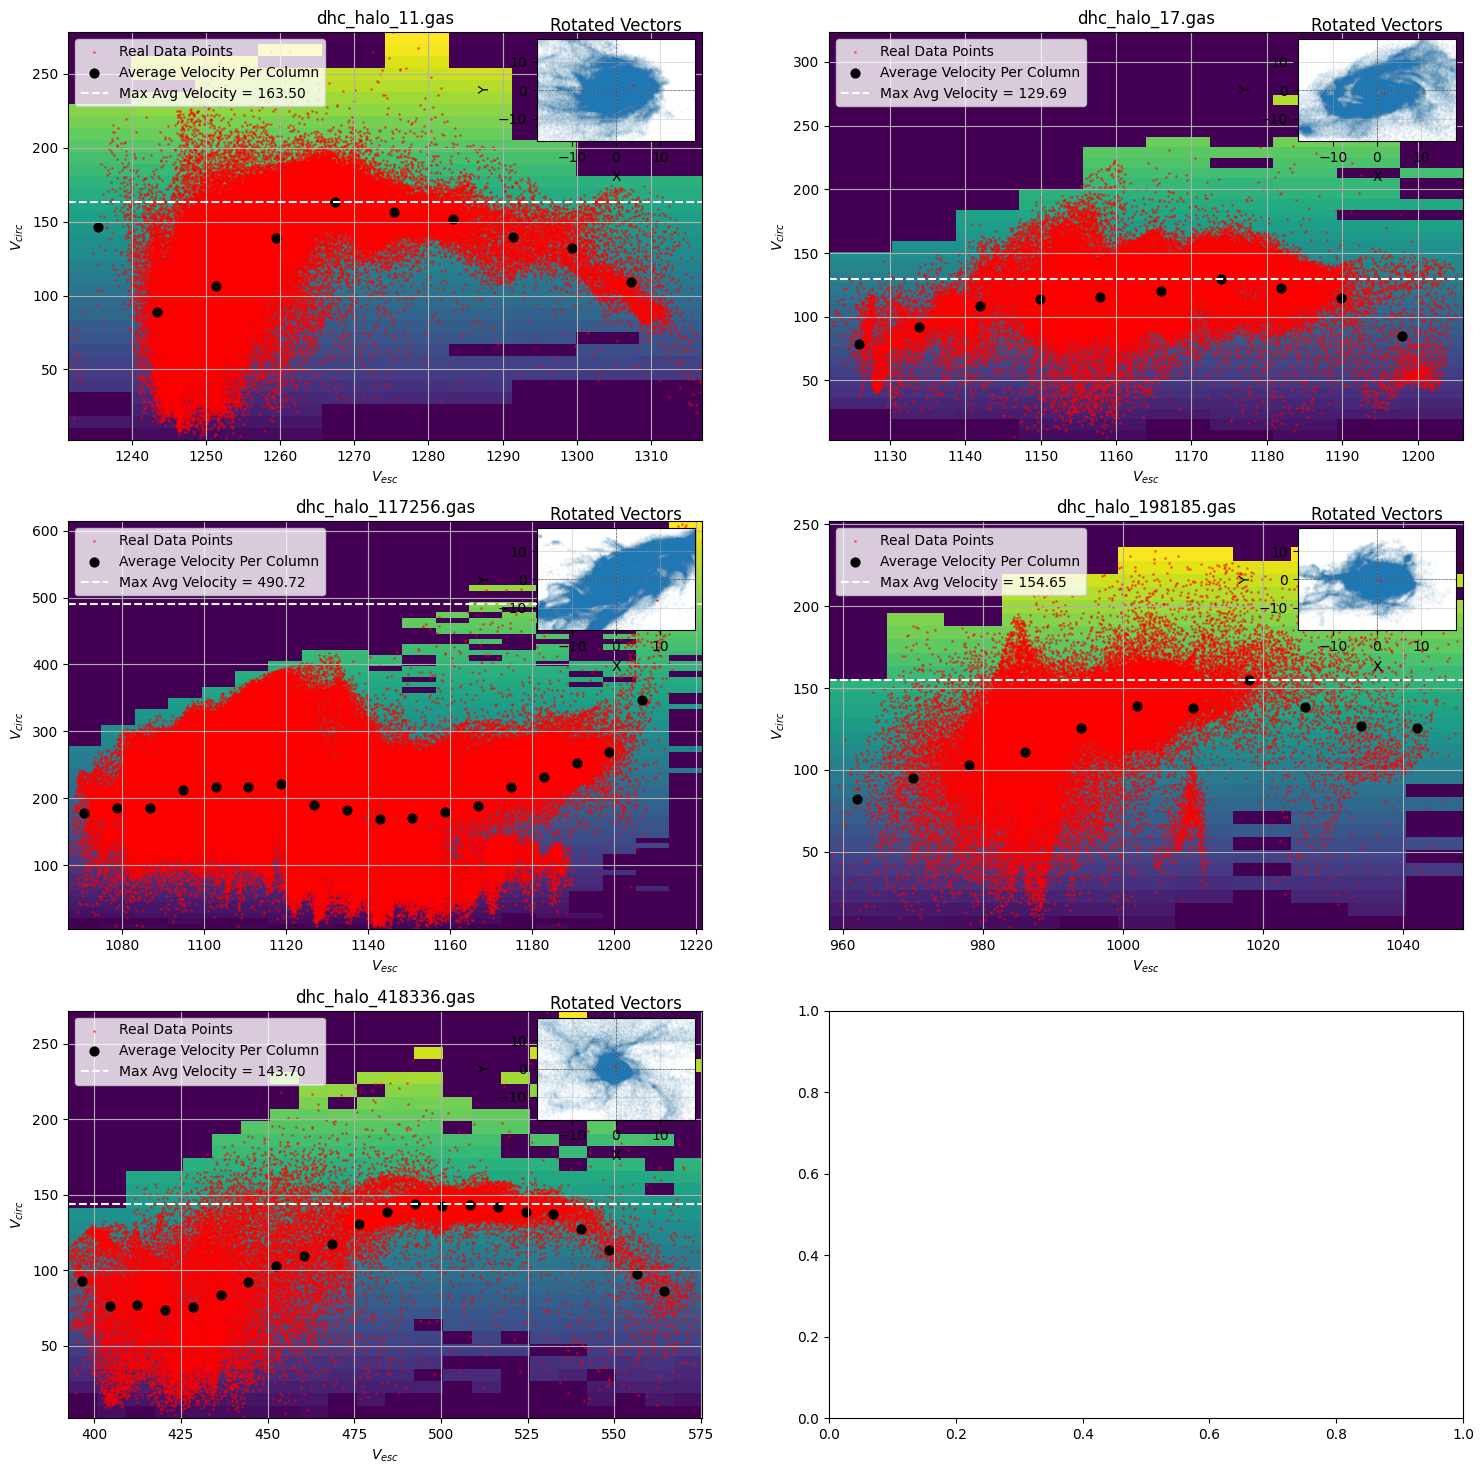

In [4]:
# Nombre de los archivos
halo_files = ['dhc_halo_11.gas', 'dhc_halo_17.gas', 'dhc_halo_117256.gas', 'dhc_halo_198185.gas', 'dhc_halo_418336.gas']

fig, axs = plt.subplots(3, 2, figsize=(18, 18))
axs = axs.flatten()

for idx, file_path in enumerate(halo_files):
    simulation = TNG50DataProcessor(file_path)
    center_of_mass = simulation.calculate_center_of_mass_new(2.63)
    total_angular_momentum = simulation.calculate_total_angular_momentum()
    angular_direction = np.sign(total_angular_momentum)
    largest_component = np.argmax(np.abs(total_angular_momentum))
    direction = angular_direction[largest_component]

    rotation_handler = RotationHandler(direction)
    angle_rotation_matrix = rotation_handler.choose_rotation_matrix(largest_component, direction)

    original_vectors = simulation.accumulated_data[:, :3]
    velocity_vectors = simulation.accumulated_data[:, 3:6]
    rotated_vectors_position = rotation_handler.apply_rotation(angle_rotation_matrix, original_vectors)
    rotated_vectors_velocity = rotation_handler.apply_rotation(angle_rotation_matrix, velocity_vectors)

    rotated_data = np.concatenate([rotated_vectors_position, rotated_vectors_velocity, simulation.accumulated_data[:, 6:]], axis=1)
    potential = simulation.accumulated_data[:, 9]

    #Para los datos rotados se calculan magnitudes y cantidades
    calculator = VelocityEscapeCalculator(rotated_data, potential)
    calculator.calculate_magnitudes()
    calculator.calculate_escape_velocity()

    processed_data = calculator.get_processed_data()

    #Grid
    v_circ_min, v_circ_max = processed_data['velocity_magnitude'].min(), processed_data['velocity_magnitude'].max()
    v_esc_min, v_esc_max = processed_data['escape_velocity'].min(), processed_data['escape_velocity'].max()

    v_circ_bins = np.arange(v_circ_min, v_circ_max, 8)
    v_esc_bins = np.arange(v_esc_min, v_esc_max, 8)

    grid_data = np.zeros((len(v_circ_bins) - 1, len(v_esc_bins) - 1))
    point_density = np.zeros((len(v_circ_bins) - 1, len(v_esc_bins) - 1))

    for i, j in [(i, j) for i in range(len(v_circ_bins) - 1) for j in range(len(v_esc_bins) - 1)]:
        mask = ((processed_data['velocity_magnitude'] >= v_circ_bins[i]) &
                (processed_data['velocity_magnitude'] < v_circ_bins[i + 1]) &
                (processed_data['escape_velocity'] >= v_esc_bins[j]) &
                (processed_data['escape_velocity'] < v_esc_bins[j + 1]))
        points_in_cell = processed_data[mask]['velocity_magnitude']
        point_density[i, j] = len(points_in_cell)
        if len(points_in_cell) > 0:
            grid_data[i, j] = np.average(points_in_cell, weights=points_in_cell)

    weighted_avg_velocity_per_column = [
        np.average(grid_data[:, j], weights=point_density[:, j]) if np.sum(point_density[:, j]) > 0 else np.nan
        for j in range(grid_data.shape[1])
    ]

    weighted_avg_velocity_per_column = np.array(weighted_avg_velocity_per_column)
    v_esc_midpoints = (v_esc_bins[:-1] + v_esc_bins[1:]) / 2
    max_avg_velocity = np.nanmax(weighted_avg_velocity_per_column)

    ax = axs[idx]
    ax.imshow(grid_data, origin='lower', aspect='auto', extent=[v_esc_min, v_esc_max, v_circ_min, v_circ_max], cmap='viridis')
    ax.scatter(processed_data['escape_velocity'], processed_data['velocity_magnitude'], color='red', s=1, alpha=0.45, label='Real Data Points')
    ax.scatter(v_esc_midpoints, weighted_avg_velocity_per_column, color='black', s=40, label='Average Velocity Per Column')
    ax.axhline(y=max_avg_velocity, color='white', linestyle='--', label=f'Max Avg Velocity = {max_avg_velocity:.2f}')
    ax.set_title(f'{file_path}')
    ax.set_xlabel(r'$V_{esc}$')
    ax.set_ylabel(r'$V_{circ}$')
    ax.legend(loc=2)
    ax.grid(True)

    ax_inset = inset_axes(ax, width="25%", height="25%", loc=1)
    visualization = VisualizationHandler()
    visualization.visualize_galaxy_one(rotated_vectors_position, center_of_mass, ax_inset, f'Rotated Vectors')

#plt.tight_layout()
plt.show();
